# Spotify Trend Prediction Model
## Imports And Data Overview

In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import joblib
import seaborn as sns
import numpy as np
import chardet

In [2]:
spotify_data = pd.read_csv("spotify_2023_utf.csv")
total_rows = spotify_data.shape[0]  # Extracting the number of rows from the shape attribute

print("Total number of rows:", total_rows)

Total number of rows: 953


### Overview

In [40]:
spotify_data

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974.0,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817.0,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322.0,84,...,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363.0,61,...,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870.0,4,...,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683.0,2,...,92,C#,Major,80,81,67,4,0,8,6
951,En La De Ella,"Feid, Sech, Jhayco",3,2022,10,20,1320,0,133895612.0,29,...,97,C#,Major,82,67,77,8,0,12,5


In [4]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

From the dataframe info I have gathered that streams is an object. But displayed as an int. So further modifications need to be made to the dataset to convert the values to int.

## Null Check And Data Clean Up

Convert streams column to int

In [5]:
spotify_data['streams'] = pd.to_numeric(spotify_data['streams'], errors='coerce')
print(spotify_data.dtypes)

track_name               object
artist(s)_name           object
artist_count              int64
released_year             int64
released_month            int64
released_day              int64
in_spotify_playlists      int64
in_spotify_charts         int64
streams                 float64
in_apple_playlists        int64
in_apple_charts           int64
in_deezer_playlists      object
in_deezer_charts          int64
in_shazam_charts         object
bpm                       int64
key                      object
mode                     object
danceability_%            int64
valence_%                 int64
energy_%                  int64
acousticness_%            int64
instrumentalness_%        int64
liveness_%                int64
speechiness_%             int64
dtype: object


In [6]:
pd.isnull(spotify_data).any()

track_name              False
artist(s)_name          False
artist_count            False
released_year           False
released_month          False
released_day            False
in_spotify_playlists    False
in_spotify_charts       False
streams                  True
in_apple_playlists      False
in_apple_charts         False
in_deezer_playlists     False
in_deezer_charts        False
in_shazam_charts         True
bpm                     False
key                      True
mode                    False
danceability_%          False
valence_%               False
energy_%                False
acousticness_%          False
instrumentalness_%      False
liveness_%              False
speechiness_%           False
dtype: bool

In this case there are two columns that have null values that could provide inaccurate data.

### Clean Up

In [7]:
df = spotify_data.dropna(how='any',axis=0) 
total_rows = df.shape[0]  # Extracting the number of rows from the shape attribute

print("Total number of rows:", total_rows)

Total number of rows: 816


In [8]:
pd.isnull(df).any()

track_name              False
artist(s)_name          False
artist_count            False
released_year           False
released_month          False
released_day            False
in_spotify_playlists    False
in_spotify_charts       False
streams                 False
in_apple_playlists      False
in_apple_charts         False
in_deezer_playlists     False
in_deezer_charts        False
in_shazam_charts        False
bpm                     False
key                     False
mode                    False
danceability_%          False
valence_%               False
energy_%                False
acousticness_%          False
instrumentalness_%      False
liveness_%              False
speechiness_%           False
dtype: bool

## Data Research and Correlations

### Min, Max and Mean values in each column

In [9]:
df.min()

track_name              'Till I Collapse
artist(s)_name                  (G)I-DLE
artist_count                           1
released_year                       1930
released_month                         1
released_day                           1
in_spotify_playlists                  31
in_spotify_charts                      0
streams                           2762.0
in_apple_playlists                     0
in_apple_charts                        0
in_deezer_playlists                    0
in_deezer_charts                       0
in_shazam_charts                       0
bpm                                   65
key                                    A
mode                               Major
danceability_%                        23
valence_%                              4
energy_%                              14
acousticness_%                         0
instrumentalness_%                     0
liveness_%                             3
speechiness_%                          2
dtype: object

In [41]:
df.max()

track_name              ýýýýýýýýýýýýýýýýýýýýý
artist(s)_name                           teto
artist_count                                8
released_year                            2023
released_month                             12
released_day                               31
in_spotify_playlists                    52898
in_spotify_charts                         147
streams                          3562543890.0
in_apple_playlists                        532
in_apple_charts                           275
in_deezer_playlists                        99
in_deezer_charts                           45
in_shazam_charts                           99
bpm                                       206
key                                        G#
mode                                    Minor
danceability_%                             96
valence_%                                  97
energy_%                                   97
acousticness_%                             97
instrumentalness_%                

In [11]:
df.mean(numeric_only=True)

artist_count            1.568627e+00
released_year           2.018517e+03
released_month          6.024510e+00
released_day            1.371201e+01
in_spotify_playlists    4.852316e+03
in_spotify_charts       1.173652e+01
streams                 4.689858e+08
in_apple_playlists      6.021569e+01
in_apple_charts         4.953431e+01
in_deezer_charts        2.454657e+00
bpm                     1.225809e+02
danceability_%          6.740931e+01
valence_%               5.117279e+01
energy_%                6.435662e+01
acousticness_%          2.633333e+01
instrumentalness_%      1.678922e+00
liveness_%              1.817034e+01
speechiness_%           1.053554e+01
dtype: float64

From here we can gather the scope of the dataset and the reach, any outliers can be discovered (Which will be tested for next). Columns such as years and months can be disregarded as their rows are seen as labels in the context of a model. Of which the time of year wont be a independent value in this test.

### Dependant Variable

What I want to predict. In this case I want to predict the number of streams you possibly can get.

In [12]:
y = DataFrame(df, columns=['streams'])

### Outliers In Stream Column

In [42]:
y

,danceability_%
0,80
1,71
2,51
3,55
4,65
...,...
948,60
949,42
950,80
951,82


y has a postive skew. The mean is greater than the median. This means that there are some high values pulling the mean in the positive direction. Models usually assume a normal distribution of data for optimal performance. Skewed data might lead to biased models.

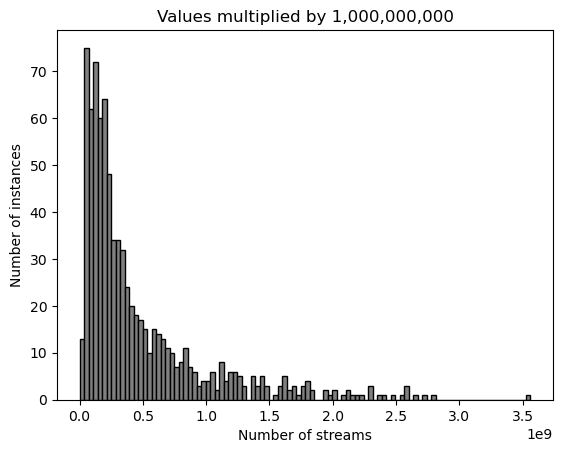

In [14]:
plt.hist(y, bins=100, ec='black', color='gray')
plt.xlabel("Number of streams")
plt.ylabel('Number of instances')
plt.title("Values multiplied by 1,000,000,000")
plt.show()

We clearly see that the lower 500 000 000 streams has a higher weight causing the skew in the column. 

#### Improving skew with log

A way to normalise the data set would be to use log as Logarithms compress large values more than small values. 

In [15]:
y_log = np.log(y)

In [16]:
y_log.skew()

streams   -1.346345
dtype: float64

The skewness has been improved

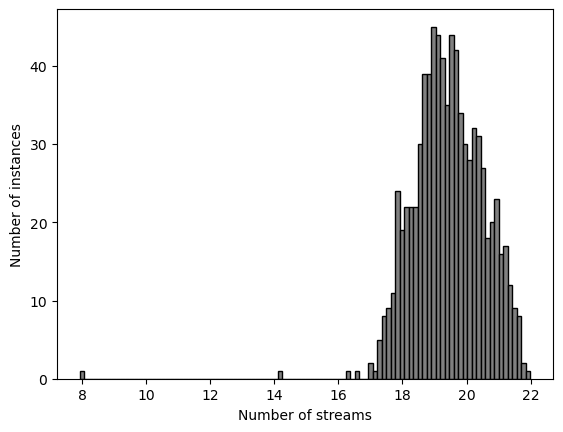

In [17]:
plt.hist(y_log, bins=100, ec='black', color='gray')
plt.xlabel("Number of streams")
plt.ylabel('Number of instances')
plt.show()

### Independant Values

#### Testing corelations

For the next test I am selecting a few columns that I think would help predict the total streams and testing the correlation as a Linear Regression dataset

In [18]:
x = DataFrame(df, columns=['bpm', 'danceability_%', 'energy_%', 'acousticness_%', 'in_spotify_playlists', 'instrumentalness_%', 'liveness_%', 'speechiness_%'])

##### Bpm test

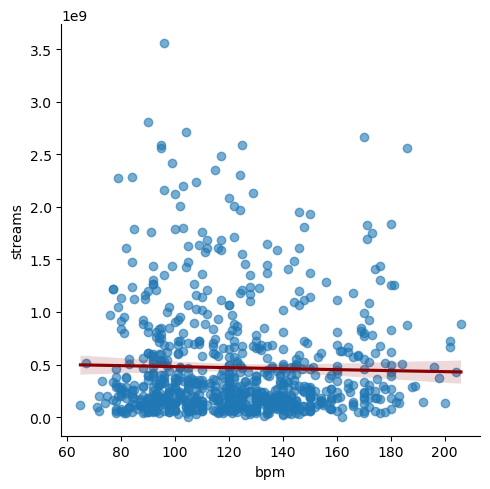

In [19]:
sns.lmplot(x="bpm", y="streams", data=df, scatter_kws={'alpha': 0.6}, line_kws={'color': 'darkred'})
plt.show()

The scatter plot indicates a high scatter indicating a possible low correlation. This could also be because the streams have some outliers in the higher streams above 1000 000 000.

##### Clipping the values to eliminate outliers

In [20]:
lower_limit = 0
upper_limit = 1000000000

new_df = df.copy()

# Using .loc to modify the DataFrame
new_df['streams'] = new_df['streams'].clip(lower=lower_limit, upper=upper_limit)

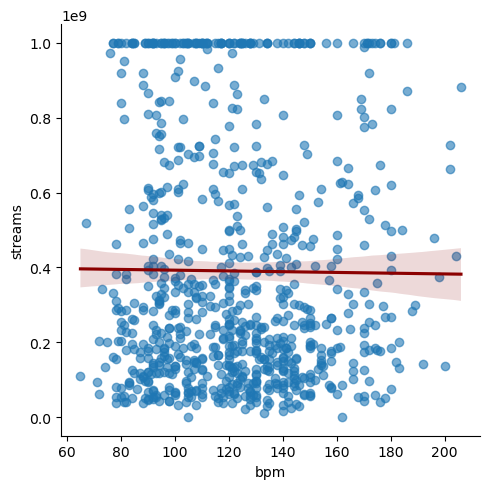

In [21]:
sns.lmplot(x="bpm", y="streams", data=new_df, scatter_kws={'alpha': 0.6}, line_kws={'color': 'darkred'})
plt.show()

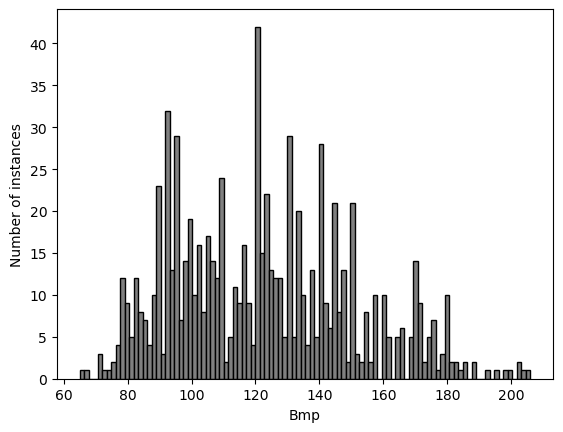

0.43122396597614276


In [22]:
plt.hist(x['bpm'], bins=100, ec='black', color='gray')
plt.xlabel("Bmp")
plt.ylabel('Number of instances')
plt.show()
print(x['bpm'].skew())

Bpm has very little correlation

In [23]:
x.drop(columns=['bpm'], inplace=True)

##### Heatmap and Pair Plot

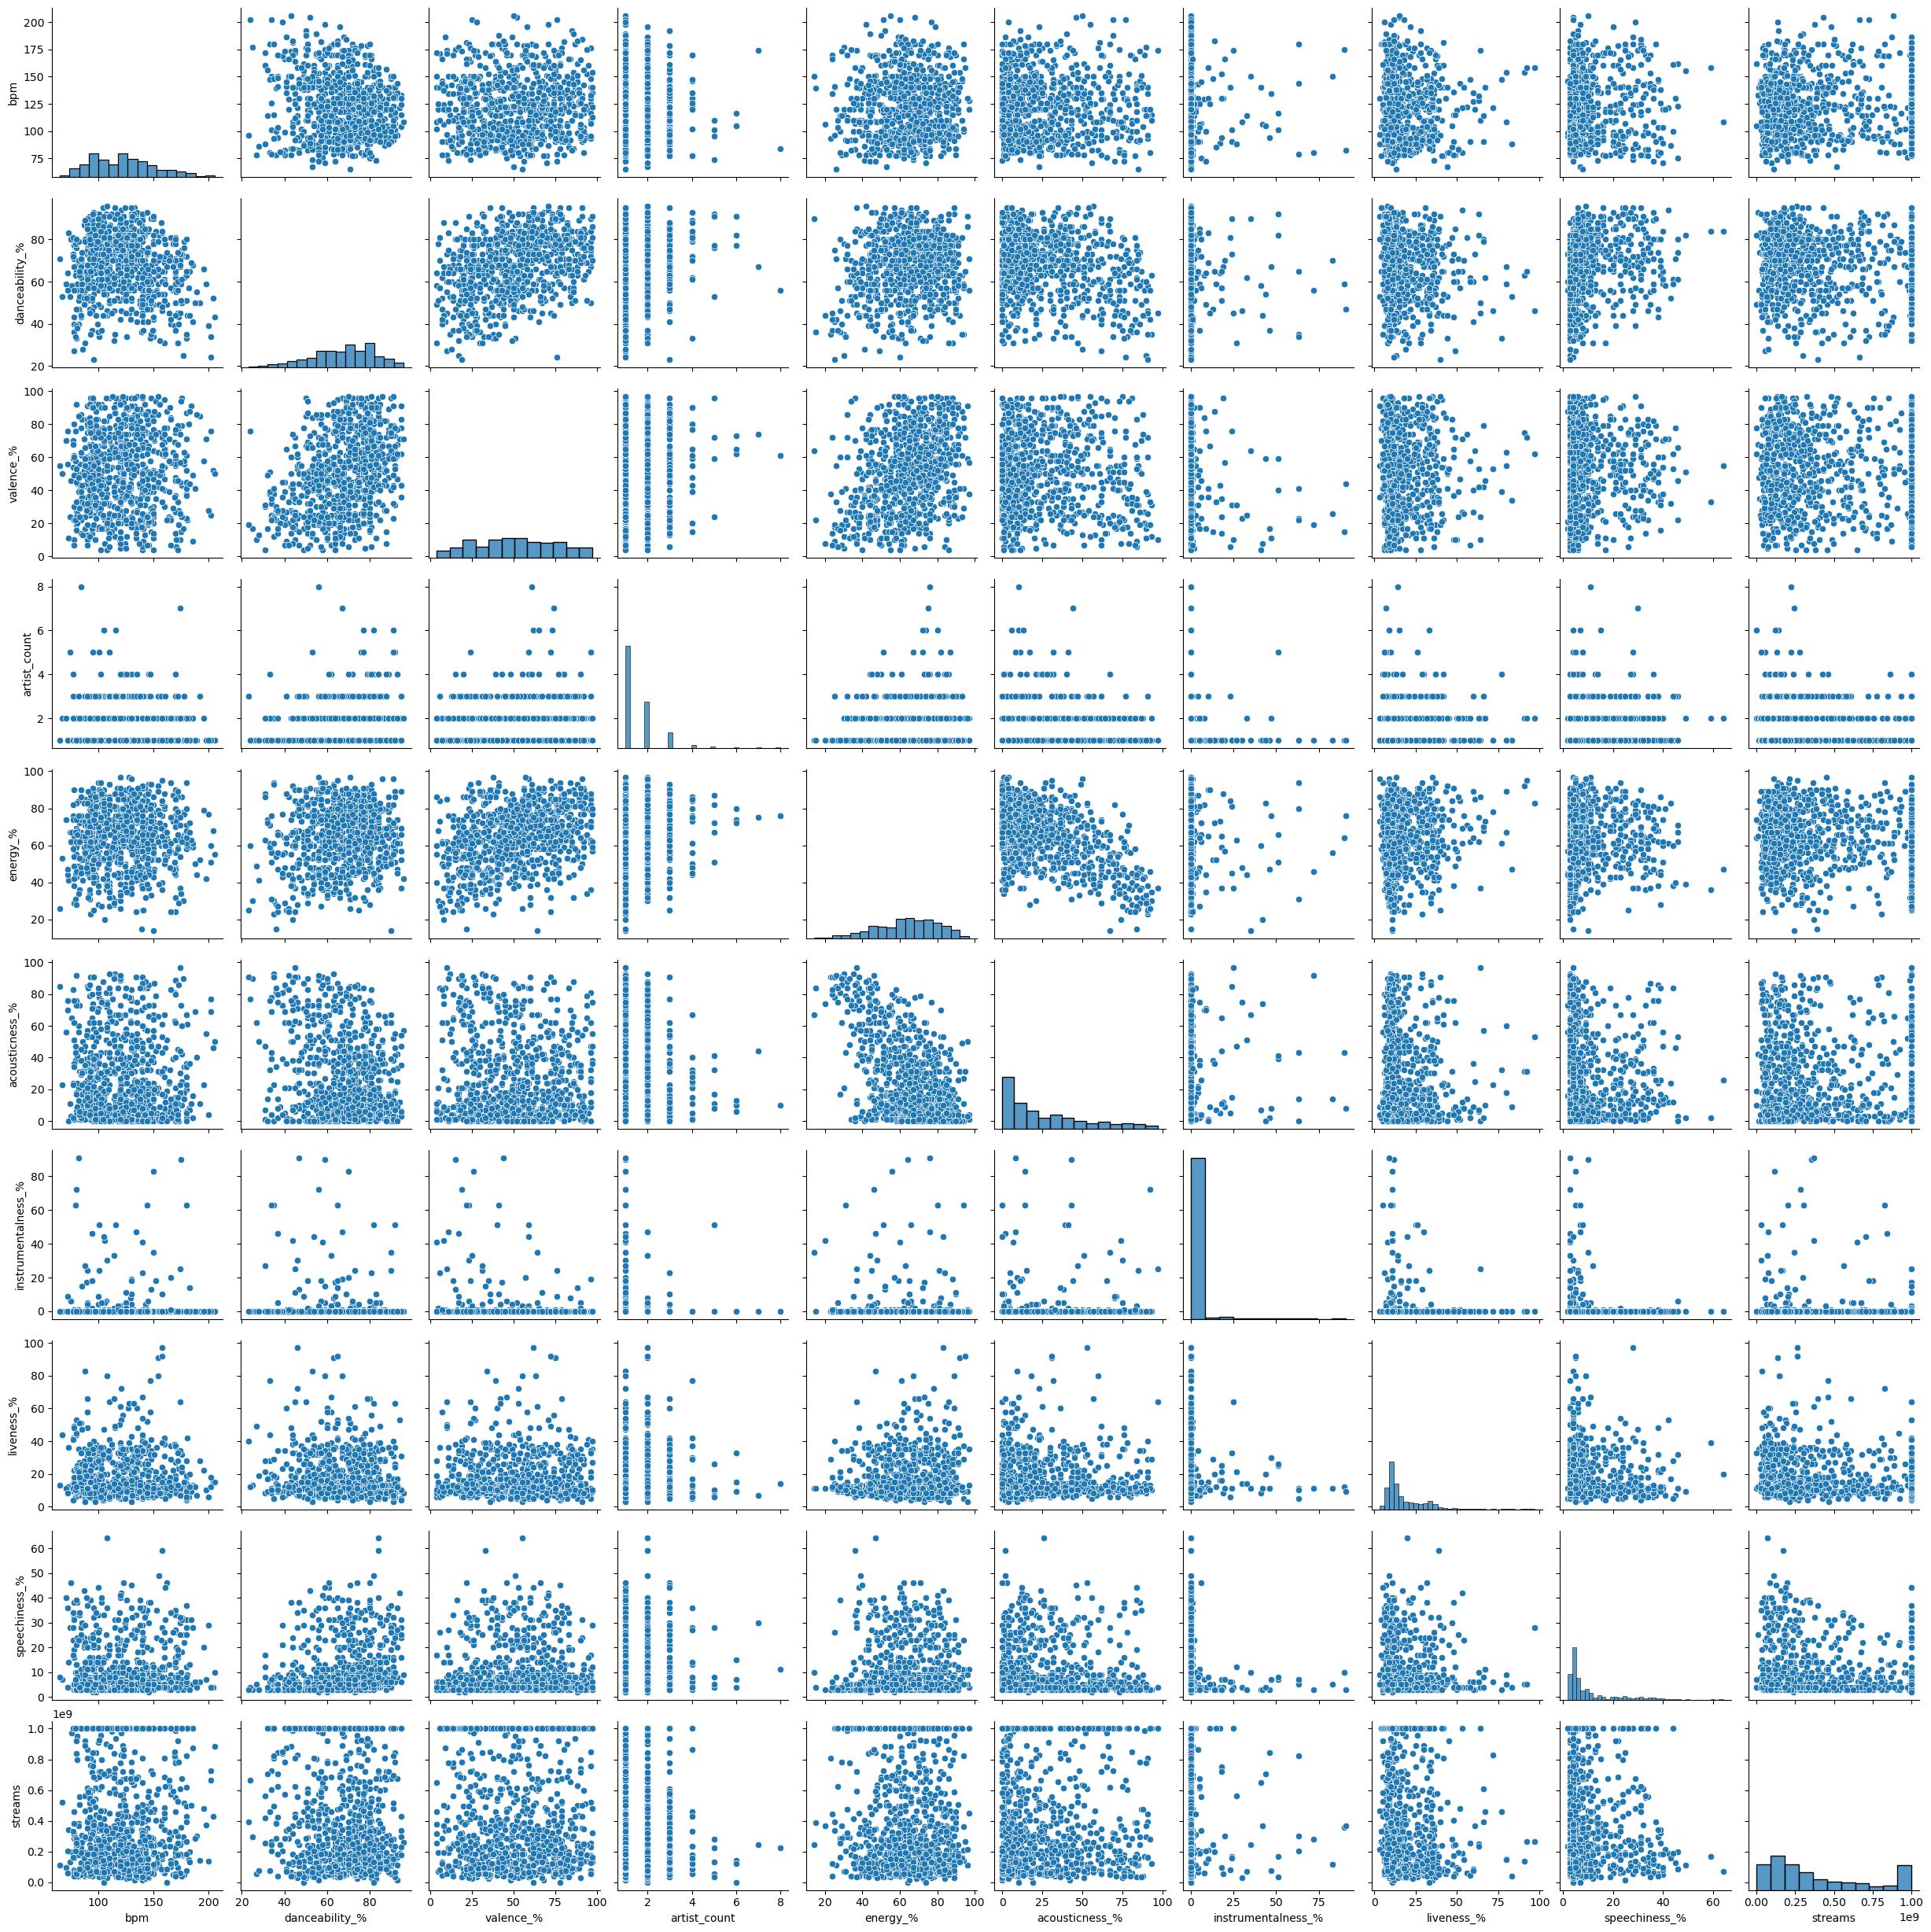

In [24]:
testing_df= DataFrame(new_df, columns=['bpm', 'danceability_%', 'valence_%', 'artist_count', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'streams'])

sns.pairplot(testing_df)
plt.show()

The Pair plot located in the final column examines potential relationships with streams. The'shoe shape' represents the linearity indicators that are displayed by speechiness, liveliness, and acousticness. 

C:\Users\reina\AppData\Local\Temp\ipykernel_13992\4096601637.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = spotify_data.corr()


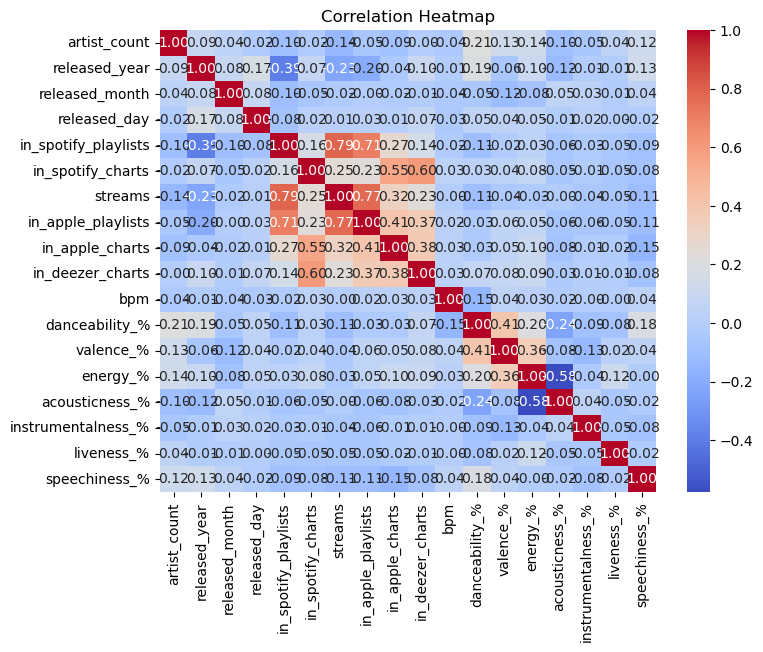

In [25]:
correlation_matrix = spotify_data.corr()

# Create a correlation heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#### Results and Changes after correlation testing

All columns have a stronger negative association on streams, according to the heatmap, but they are also closer to 0, which denotes essentially no correlation. The Danceability column shows potential as a y value, which describes stronger impacts and relationships. For instance, there is a positive linear association with values closer to 1 between talkiness and energy. Since the minus values affect the dependent value as well, they are not ignored.

### New Independant and Dependant values

In [26]:
y = DataFrame(new_df, columns=['danceability_%'])

# x values were determend by the heatmap. Any columns with a postive correlation higher than 0.15 and columns with any negative correlation lower than -0.15
x = DataFrame(new_df, columns=['bpm', 'energy_%', 'acousticness_%', 'in_spotify_playlists', 'speechiness_%', 'valence_%', 'artist_count',])

#### x Skew values

In [27]:
for column in x.columns:
    col_skew = x[column].skew()  # Calculate skewness for the column, dropping NaN values
    print(f"Skewness of '{column}': {col_skew}")

Skewness of 'bpm': 0.43122396597614276
Skewness of 'energy_%': -0.38072340103730046
Skewness of 'acousticness_%': 0.9702110743781299
Skewness of 'in_spotify_playlists': 3.1545315548624044
Skewness of 'speechiness_%': 1.8331109487144102
Skewness of 'valence_%': 0.024200599326330785
Skewness of 'artist_count': 2.2608820211731313


In [28]:
# bpm, in_spotify_playlists, speechiness_%", artist_count improve when normalised
x_log_test = np.log(x["bpm"])
x_log_test.skew()

-0.012281862334001864

#### Applying log to some x columns to normalise them

In [43]:
columns_to_log = ['bpm', 'in_spotify_playlists', 'speechiness_%', 'artist_count'] 

# x = x.copy()

# for col in columns_to_log:
#     if col in x.columns:
#         x[col] = np.log1p(x[col])  # Applying log transformation (np.log1p() handles 0 and negative values)
#     else:
#         print(f"Column '{col}' not found in the DataFrame.")
        
# x

#skipped as it did not improve much

## Training Set Up

### Splits and Model Training

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=24)

In [31]:
regr = LinearRegression()
regr.fit(x_train, y_train)

LinearRegression()

### Coefficients

In [32]:
coef_data = regr.coef_.reshape(-1, 1)
pd.DataFrame(data=coef_data, index=x_train.columns, columns=['coef'])

,coef
bpm,-8.524284
energy_%,-0.148007
acousticness_%,-0.157870
in_spotify_playlists,-0.759352
speechiness_%,4.130530
valence_%,0.249765
artist_count,5.496099


Coefficients indicates the x values impact on the y. In this case acousticness has the largest impact, although negatively.

### Model Accuracy

In [33]:
print('Trainng data r-squared:', regr.score(x_train, y_train))
print('Test data r-squared:', regr.score(x_test, y_test))

Trainng data r-squared: 0.2891934032351454
Test data r-squared: 0.34460182486188873


The r squared indicated a perfect fit. Which is great but that could also mean the model might be over fit. Meaning its too complex and fits the training data too closely.

## Testing Model Fit (if its overfit)

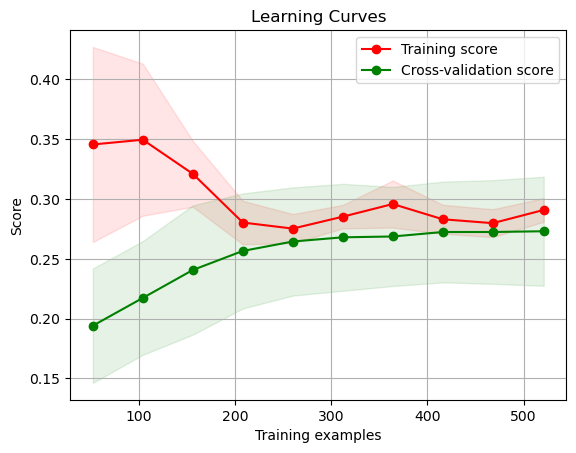

In [34]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='r2')  # You can use other scoring metrics

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure()
    plt.title('Learning Curves')
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curves
plot_learning_curve(regr, x_train, y_train)

Values around 100 in our Training examples indicates variance. High variance models are overly sensitive to fluctuations. This could Indicate that the model is too complex for the number of data provided. I would need more data potentially.

## Hyperparameters

 Random Search randomly samples combinations of hyperparameters, which can save time and computational resources. However, whether Random Search is better than Grid Search depends on your specific problem and dataset.

In [35]:
param_dist = {
    'alpha': np.logspace(-3, 3, 100),  # Range of alpha values to test
    'fit_intercept': [True, False],
}

ridge = Ridge()

random_search_model = RandomizedSearchCV(ridge, param_distributions=param_dist, n_iter=200, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

random_search_model.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=200, n_jobs=-1,
                   param_distributions={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                                        'fit_intercept': [True, False]},
                   scoring='neg_mean_absolute_error')

### Gather the best parameters

In [36]:
best_params = random_search_model.best_params_

best_model = random_search_model.best_estimator_

y_pred = random_search_model.predict(x_test)
y_pred_train = random_search_model.predict(x_train)

### Model Evaluation

In [37]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_pred_train)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared_Test: {r2_test}')
print(f'R-squared_Train: {r2_train}')

coefficients = best_model.coef_.reshape(-1, 1)
pd.DataFrame(data=coefficients, index=x_train.columns, columns=['coef'])

MAE: 9.265371691806669
MSE: 130.4553622366568
R-squared_Test: 0.34460154175045854
R-squared_Train: 0.28919340321679743


,coef
bpm,-8.524041
energy_%,-0.148007
acousticness_%,-0.157870
in_spotify_playlists,-0.759353
speechiness_%,4.130521
valence_%,0.249765
artist_count,5.496007


## Last Notes

The end result indicated the model has a accuracy of arround 34% after Hyperparemeters have been implemented which in this case yielded no drastic increase, in this case it might be due to the small dataset size. Initially the x values only consisted of bpm energy_% acousticness_% speechiness_% which gave an accuracy of 11%. By adding more variables that have larger correlations (as tested on heatmap) the accuracy improved. Some of the x columns have also been normalized(log) which yielded a 1% increase. The model can no longer be improved within my skillset, a larger dataset will also be needed.

## Model Export

In [39]:
model_filename = "Spotify_SongDanceability_Predicter.pkl"

joblib.dump(best_model, model_filename)

model_info = {
    "model": best_model,
    "features": list(x.columns)
}

joblib.dump(model_info, "model_info.pkl")

['model_info.pkl']